Forecasting solar energy:
The data is taken from AMS 2013-2014 solar energy prediction contest input datset posted at the kaggle website.
First We will prepare the precipitation data

In [3]:
import netCDF4 as nc
import numpy as np
import pandas as pd
data = nc.Dataset("C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\gefs_train\\train\\tmp_2m_latlon_subset_19940101_20071231.nc")
for v in data.variables.keys():
    print(v)
#data.variables.values()

for d in data.dimensions.values():
    print(d)

lat = data.variables['lat']
print(lat.shape)
lon = data.variables['lon']
print(lon.shape)
t = data.variables['Temperature_height_above_ground']
print(t.shape)
l = lat[:]
n = lon[:]


time
intTime
lat
lon
ens
fhour
intValidTime
Temperature_height_above_ground
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 5113

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 9

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 16

<class 'netCDF4._netCDF4.Dimension'>: name = 'ens', size = 11

<class 'netCDF4._netCDF4.Dimension'>: name = 'fhour', size = 5

(9,)
(16,)
(5113, 11, 5, 9, 16)


We need the grid points from lat: 33 - 37 (5), lon: 257 - 266 (10), so 5 x 10 = 50 grid points instead of 9 x 16 grid points.
We have to loop under loop to create data at each grid point
First the data is extracted for each grid points(5113, 11, 5). Then the average over 11 model is done (5113, 5). Then average on 5 time steps are done to get the daily avg (5113). Then for a given date precipitation data is extracted (1 element). The data is looped over the entire grid to get daily avg precipitation data over the entire grid (p_daily).
Then intensity plot for precipitation is done
Then precipitation for individual station is estmated by 2d interpolation


In [4]:
## Reshaping data file for a smaller grid (latitude range 33 - 38, longitude range 257 - 267) 
for lat in range(33, 38): 
    l_in = np.where(l == lat)[0][0]
    for lon in range(257, 267):
        n_in = np.where(n == lon)[0][0]
        filename = 't_'+str(lat)+ '_'+str(lon)
        fileval = t[:,:,:,l_in,n_in]
        #print(filename, fileval.shape)
        # reshaping fileval from (5113, 11, 5) to (5113, 55)
        fileval = fileval.reshape(fileval.shape[0], fileval.shape[1]*fileval.shape[2])
        #print(filename, fileval.shape)
        # saving the  data for each grid point
        filepath = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Solar energy/Data/Temp/" + filename +str('.csv')
        np.savetxt(filepath, fileval, delimiter=',', fmt = "%0.06f")


enter a station id (stid column) from the station listACME
['34_261', '34_262', '35_261', '35_262']
250.83671600000002 319.109375
count    281215.000000
mean        292.625242
std          10.714237
min         250.836716
25%         284.460877
50%         293.255188
75%         301.054902
max         319.109375
Name: value, dtype: float64
          0         5         10        15        20        25        30  \
0   1.000000  0.999231  0.999013  0.999018  0.999035  0.999010  0.998968   
5   0.999231  1.000000  0.997647  0.998088  0.998318  0.998276  0.998246   
10  0.999013  0.997647  1.000000  0.997962  0.998080  0.998171  0.998174   
15  0.999018  0.998088  0.997962  1.000000  0.998038  0.998058  0.998159   
20  0.999035  0.998318  0.998080  0.998038  1.000000  0.998199  0.997905   
25  0.999010  0.998276  0.998171  0.998058  0.998199  1.000000  0.998004   
30  0.998968  0.998246  0.998174  0.998159  0.997905  0.998004  1.000000   
35  0.999014  0.998471  0.998206  0.998085  0.9981

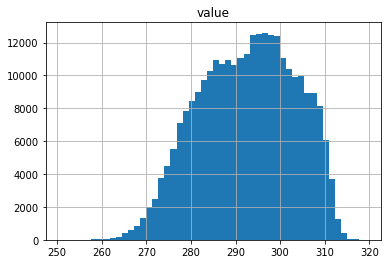

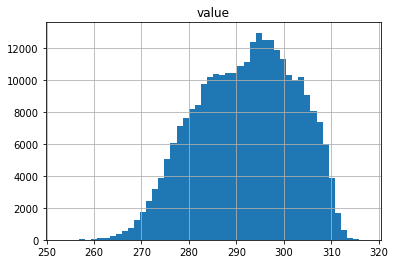

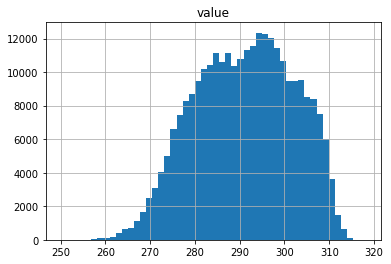

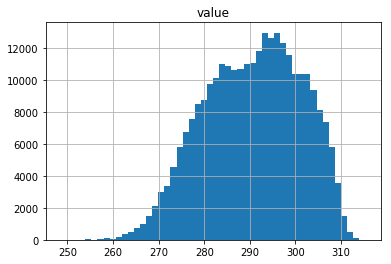

In [6]:
# Now we need work on 4 surrounding grid points to the station
import math
station_loc = pd.read_csv("C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\station_info.csv", index_col='stid')
station_name = str(input('enter a station id (stid column) from the station list'))
stn_n_l_e = station_loc.loc[station_name]
stn_n = stn_n_l_e[0]
stn_l = stn_n_l_e[1] + 360
#print(stn_n, stn_l)
Xnew=stn_l
Ynew=stn_n
str_list = [str(math.floor(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.floor(Ynew)) +'_'+ str(math.ceil(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.ceil(Xnew))]
print(str_list)
filepath = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\t_"
filename1 = filepath + str_list[0] + '.csv'
filename2 = filepath + str_list[1] + '.csv'
filename3 = filepath + str_list[2] + '.csv'
filename4 = filepath + str_list[3] + '.csv'
filenames = [filename1, filename2, filename3, filename4]

for k in range(4):
    
    p_grid = pd.read_csv(filenames[k], header=None)
    # Null data
    
    assert pd.notnull(p_grid).all().all()
    # Checking minimum value: no -ve precipitation
    print(p_grid.min().min(), p_grid.max().max())
    # reshaping: from 2d:5113 x 55 to 1d: 281215
    p = p_grid.melt()
    print(p.describe().value)
    p.hist(bins= 50, column='value')

    
    # There are 5 timesteps in a day (lets say: t0, t1, t2, t3, t4): at timestep t0
    # we will combine 11 model prediction at timestep t0
    model_en_t0 = p_grid[0]
    for i in range(0,50,5):
    
        model_en_t0 = pd.concat([model_en_t0, p_grid[i+5]], axis=1)
    
    #print(model_en)
    # how close are the prediction from each model!!
    print(model_en_t0.corr())
    
    # Averaging the model prediction at t0 time step
    model_mean_t0 = np.mean(model_en_t0, axis=1)
    
    #np.savetxt("model_en_35_261_t0.csv", model_mean_t0, delimiter=',', fmt = "%0.03f")
    
    # for all 5 timesteps
    model_mean_t=pd.DataFrame()
    for j in range(0,5):
        #print(j)
        model_en = p_grid[j]
        for i in range(0,50,5):
            model_en = pd.concat([model_en, p_grid[i+j+5]], axis=1)
        model_mean = np.mean(model_en, axis=1)
    
        model_mean_t = pd.concat([model_mean_t, model_mean], axis=1)
    #print(model_mean_t)
    # lets average the value over the timesteps
    model_mean_t_mean = np.mean(model_mean_t, axis=1)
    #print(model_mean_t_mean)
    filepath1 = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\model_t_mean_"
    filename= filepath1 + str_list[k] + '.csv'
    print(filename)
    np.savetxt(filename, model_mean_t_mean, delimiter=',', fmt = "%0.06f")


[282.57355931 282.38980952 276.0974945  ... 273.39041326 275.30748221
 276.66203226]


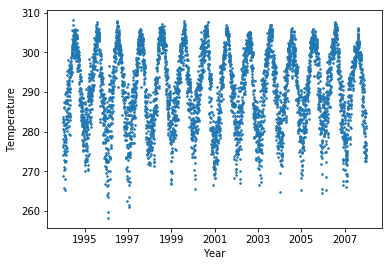

In [7]:
# Now we need to interpolate the precipitation values from 4 surrounding grid points to the station
import math
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
x,y = np.meshgrid([math.floor(Xnew), math.ceil(Xnew)],[math.floor(Ynew), math.ceil(Ynew)])

# math.floor(Xnew), math.ceil(Xnew), math.floor(Ynew), math.ceil(Ynew)
str_list = [str(math.floor(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.floor(Ynew)) +'_'+ str(math.ceil(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.ceil(Xnew))]

filepath = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\model_t_mean_"
filename1 = filepath + str_list[0] + '.csv'
filename2 = filepath + str_list[1] + '.csv'
filename3 = filepath + str_list[2] + '.csv'
filename4 = filepath + str_list[3] + '.csv'
filenames = [filename1, filename2, filename3, filename4]
var1 = pd.read_csv(filename1, header=None)
var1 = var1.rename(columns={var1.columns[0] : 'x1y1'})
var2 = pd.read_csv(filename2, header=None)
var2 = var2.rename(columns={var2.columns[0] : 'x2y1'})
var3 = pd.read_csv(filename3, header=None)
var3 = var3.rename(columns={var3.columns[0] : 'x1y2'})
var4 = pd.read_csv(filename4, header=None)
var4 = var4.rename(columns={var4.columns[0] : 'x2y2'})
var = pd.concat([var1, var2, var3, var4], axis=1)


# z structure([(34,261), (34, 262)], [(35, 261), (35, 262)])
var_station = []
for row in var.values:
    z = [row[0], row[1]], [row[2], row[3]]
    #print(z)
    f = interpolate.interp2d(x,y,z,kind='linear')
    interp_val=f(Xnew,Ynew)
    #print(type(interp_val))
    var_station = np.append(var_station, interp_val)
print(var_station)
#print(type(var_station), type(Dates.values))
filepath_var = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\t_station.csv"
np.savetxt(filepath_var, var_station, delimiter=',', fmt = "%0.06f")
## Convert Dates to datetime
from datetime import datetime
dates = np.arange(np.datetime64('1994-01-01'), np.datetime64('2008-01-01'))

#print(len(dates))
plt.scatter(dates, var_station, s=10, marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()